We investigate how valves can be used on the lightning network to establish a balanced channel. In particular we note a channel balanced if the expected liqudity distribution is close to the uniform distribution.

In particular we use Markov Chains to predict the liquidity distribution of a channel with drain and given `htlc_maximum_msat` settings. We show that tuning the `htlc_maximum_msat` parameter can be used to mitigate depletion on channels with (even high) drain by throttling the throughput of requested liquidity. This notebook investigates how expected payment failure rates may drop significantly by exploiting this tool to achieve better flow control.

This notebook also introduces the aforementioned Markov model to derive a probability distribution which encodes the uncertainty about the liquidity that comes from channels with drain and valves. 

## Structure of the notebook:

* some helper functions
* Experiment1: symmetric `htlc_maximum_msat` review
* Experiment2: optimal asymmetric `htlc_maximum_msat` pairs
* Experiment3: Liquidity distribtion of optimally chosen `htlc_maximum_msat` pairs in channels with various drain values
* Experimental study1: Heuristic for node operatos to adopt their `htlc_maximum_msat`
* Experimental study2: Round based greedy strategy for peers to find `htlc_maximum_msat` pair
* Statistics from gossip on usage of `htlc_maximum_msat`
* Open end: Using band matrices but with a poor solver that only finds the trivial solution

## Limitations
* Due to numerical sabilities we don't compute the eigenvector but raise the matrix to a sufficiently high power and only consider 100 sats channels
* The modelled Markov Chains assume payment size distribution to be uniform from 1 sat to `htlc_maximum_msat`. This seems particularly unrealistic for large values von `htlc_maximum_msat` or very small values of `htlc_maximum_msat`. This is not a problem as we would in practice adopt the max `htlc_maximum_msat` argument anyway.

## Acknowledgements 
This notebook was creted by [Rene Pickhardt](https://ln.rene-pickhardt.de) and is a result of very helpful discussions with Krystal Maughan and Sebastian Alscher who are Rene's mentees during the 2022 Summer of Bitcoin.

The research of Rene Pickhardt is funded through [NTNU](https://www.ntnu.no/) & [BitMEX](https://blog.bitmex.com/rene-pickhardt/) and various doners at https://donation.rene-pickhardt.de and https://www.patreon.com/renepickhardt While the mentees were sponsored by [Summer of Bitcoin](https://www.summerofbitcoin.org/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_steady_state_vector_uni_amount_la(capacity, drain,max_htlc_size_a, max_htlc_size_b,debug=False,fast_compute=False):
    """
    computes the the Markov chain and steady state distribution for a channel with given drain, and
    `max_htlc_size` values 
    
    WARNING: Use fast_compute with caution. The lib for solving the system of linear equations doesn't
    seem to be nummerically stable. also the matrix is sparse and the code is not optimized for that
    """
    #TODO: not necessary! but needs to fix boundaries in if statements if omitted
    assert max_htlc_size_a+max_htlc_size_b < capacity
    dim = capacity+1
    M = np.full((dim, dim), 0., dtype=np.float64)
    for i in range(max_htlc_size_a,dim-max_htlc_size_b):
        for j in range(1,max_htlc_size_a+1): #TODO: add zipf case!
            M[i,i-j]=drain/max_htlc_size_a

        for j in range(1,max_htlc_size_b+1): #TODO: add zipf case!
            M[i,i+j]=(1-drain)/max_htlc_size_b

    for i in range(max_htlc_size_a):
        for j in range(0,i+1):
            M[i,i-j]=drain/max_htlc_size_a
            
        for j in range(1,max_htlc_size_a+1):
            M[capacity-i,capacity-i-j]=drain/max_htlc_size_a
        for j in range(0,i+1):
            M[capacity-i,capacity-i+j]=(1-drain)/max_htlc_size_b
            
        M[i,i]=drain/max_htlc_size_a*(max_htlc_size_a-i)
        
    for i in range(max_htlc_size_b):
        for j in range(1,max_htlc_size_b+1):
            M[i,i+j]=(1-drain)/max_htlc_size_b
            
        for j in range(0,i+1):
            M[capacity-i,capacity-i+j]=(1-drain)/max_htlc_size_b
    
    
        for j in range(1,max_htlc_size_a+1):
            M[capacity-i,capacity-i-j]=drain/max_htlc_size_a

        ## FIX THOSE! 
        M[capacity-i,capacity-i]=(1-drain)/max_htlc_size_b*(max_htlc_size_b-i)
        
    if debug:
        print(M)
    
    if fast_compute == False:
        r = np.linalg.matrix_power(M,512)
        res = list(reversed(r[0,]))
        s = sum(res)
        return [x/s for x in res]
    else:

        for i in range(dim):
            M[i,i] = M[i,i] -1

        res = np.linalg.solve(M.T,np.empty(dim))

        c = np.cumsum(res)[-1]
        return (list(x/c for x in reversed(res)))

Let us just show how a matrix for a channel of capacity 7 with drain 0.6 and `htlc_maximum_msat` of 2 and 4 would look like

In [3]:
compute_steady_state_vector_uni_amount_la(7,0.6,2,4,True)

[[0.6 0.1 0.1 0.1 0.1 0.  0.  0. ]
 [0.3 0.3 0.1 0.1 0.1 0.1 0.  0. ]
 [0.3 0.3 0.  0.1 0.1 0.1 0.1 0. ]
 [0.  0.3 0.3 0.  0.1 0.1 0.1 0.1]
 [0.  0.  0.3 0.3 0.1 0.1 0.1 0.1]
 [0.  0.  0.  0.3 0.3 0.2 0.1 0.1]
 [0.  0.  0.  0.  0.3 0.3 0.3 0.1]
 [0.  0.  0.  0.  0.  0.3 0.3 0.4]]


[0.08444643256542163,
 0.1086314982266671,
 0.13454708118989042,
 0.14019107262676936,
 0.12330894334920278,
 0.10903409272454229,
 0.12460874844234272,
 0.17523213087516373]

In [4]:
def expected_failure_rate(x, drain, max_htlc_size_a, max_htlc_size_b):
    """
    computes the expected failure rate of a channel given 
    * the (estimated or measured) liquidity distribution
    * max_htlc_size_a
    * max_htlc_size_b
    * (assumed or known) drain
    
    The expected failure_rate is the probability that a random payment that is supposed to be forwarded
    on the channel will fail because of missing liquidity. 
    """
    total_failure_probability = 0 
    c = len(x)
    for i in range(0,max_htlc_size_b):
        local_error = x[i]*(max_htlc_size_b-i)/max_htlc_size_b*(1-drain)
        total_failure_probability+=local_error
    for i in range(c-max_htlc_size_a,c):
        local_error = x[i]*(i-c+max_htlc_size_a+1)/max_htlc_size_a*drain
        total_failure_probability+=local_error
    return total_failure_probability


In [5]:
def kolmogorov_smirnov_distance_to_uniform(x):
    """
    needed to measure how imbalanced a channel is. 
    Note we call a channel balanced if the liquidity distribution is close to uniform
    We measure "close" by looking at the kolmogorov smirnoff distance
    """
    l = len(x)
    delta = 1/l
    uni = 0
    max_dist = 0
    for k,a in enumerate(x):
        distance = abs(a-uni)
        if distance > max_dist:
            max_dist=distance
            pos = k
        uni+=delta
    return pos, max_dist

## Experiment 1: Chaning max_htlc_size but keep the same value in both directions

We already knew this from a previous article: https://blog.bitmex.com/price-of-anarchy-from-selfish-routing-strategies/ Chaning the max_htlc_size can reduce the error rate a bit. We mainly do this to verify the result by using the markov model instead of random walks

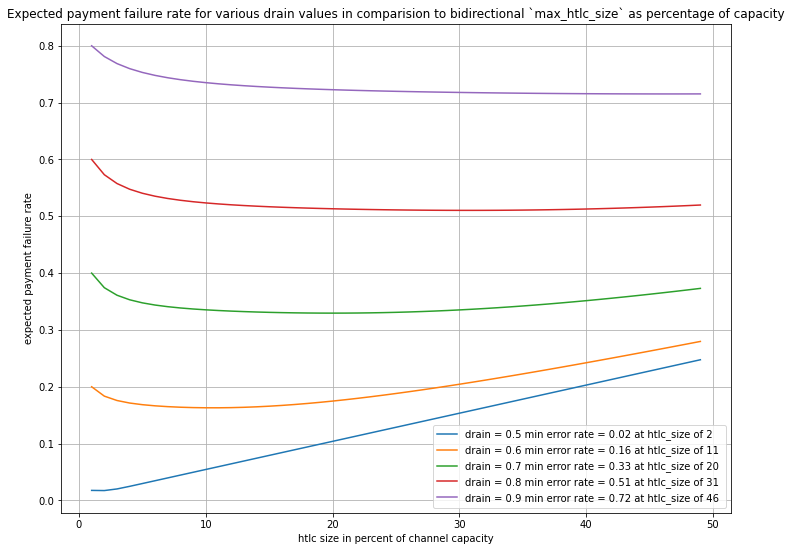

In [6]:
plt.figure(figsize=(12,9))
plt.title("Expected payment failure rate for various drain values in comparision to bidirectional `max_htlc_size` as percentage of capacity")
drains = []
expected_symmetric_failure_rates = []
for i in range(50):
    drain = 0.5+i*0.01
    xs = []
    expected_errors = []
    low = 1
    val = None
    for size in range(1,50):
        x = compute_steady_state_vector_uni_amount_la(100,drain,size ,size)
        ef = expected_failure_rate(x,drain,size,size)
        if ef < low:
            low = ef
            val = size
        xs.append(size)
        expected_errors.append(ef)
    drains.append(drain)
    expected_symmetric_failure_rates.append((low,val))
    if i%10==0:
        plt.plot(xs,expected_errors, label="drain = {:3.1f} min error rate = {:4.2f} at htlc_size of {} ".format(drain, low, val))
plt.grid()
plt.xlabel("htlc size in percent of channel capacity")
plt.ylabel("expected payment failure rate")
plt.legend(loc="lower right")
plt.show()



## Experiment 2: Compute the optimal 

In [7]:
expected_asymmetric_failure_rates = []
for i in range(5,50):
    drain = 0.5+i*0.01

    low = 1
    val = None
    for a in range(1,50):
        for b in range(1,50):
            #comment the following two line in to prevent having too small max_htlc_sizes
            #if a+b<25:
            #    continue
            x = compute_steady_state_vector_uni_amount_la(100,drain,a ,b)
            ef = expected_failure_rate(x,drain,a,b)
            if ef < low:
                low = ef
                val = (a,b)
    expected_asymmetric_failure_rates.append((low,val))
    print("Drain: {:4.2f} \t lowest failure rate: {:4.2f}% \t max_htlc_a: {:2} \tmax_htlc_b: {:2}".format(drain, 100*low, val[0],val[1]))


Drain: 0.55 	 lowest failure rate: 1.51% 	 max_htlc_a:  2 	max_htlc_b:  3
Drain: 0.56 	 lowest failure rate: 0.87% 	 max_htlc_a:  1 	max_htlc_b:  2
Drain: 0.57 	 lowest failure rate: 0.54% 	 max_htlc_a:  1 	max_htlc_b:  2
Drain: 0.58 	 lowest failure rate: 0.67% 	 max_htlc_a:  1 	max_htlc_b:  2
Drain: 0.59 	 lowest failure rate: 1.23% 	 max_htlc_a:  1 	max_htlc_b:  2
Drain: 0.60 	 lowest failure rate: 2.08% 	 max_htlc_a:  2 	max_htlc_b:  4
Drain: 0.61 	 lowest failure rate: 1.76% 	 max_htlc_a:  2 	max_htlc_b:  4
Drain: 0.62 	 lowest failure rate: 2.11% 	 max_htlc_a:  2 	max_htlc_b:  4
Drain: 0.63 	 lowest failure rate: 1.40% 	 max_htlc_a:  1 	max_htlc_b:  3
Drain: 0.64 	 lowest failure rate: 0.94% 	 max_htlc_a:  1 	max_htlc_b:  3
Drain: 0.65 	 lowest failure rate: 1.08% 	 max_htlc_a:  1 	max_htlc_b:  3
Drain: 0.66 	 lowest failure rate: 1.82% 	 max_htlc_a:  1 	max_htlc_b:  3
Drain: 0.67 	 lowest failure rate: 2.83% 	 max_htlc_a:  1 	max_htlc_b:  4
Drain: 0.68 	 lowest failure rate: 1.7

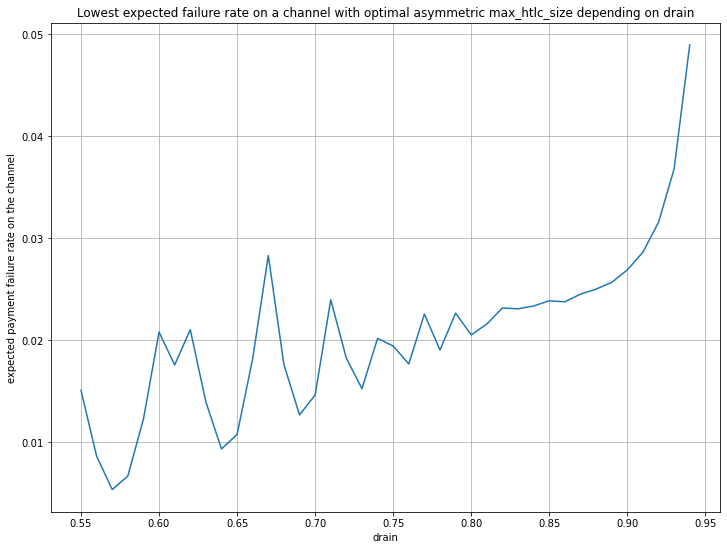

In [8]:
plt.figure(figsize=(12,9))
plt.title("Lowest expected failure rate on a channel with optimal asymmetric max_htlc_size depending on drain")
plt.plot([0.55+i*0.01 for i in range(40)], [x[0] for x in expected_asymmetric_failure_rates[:40]])
plt.grid()
plt.xlabel("drain")
plt.ylabel("expected payment failure rate on the channel")
plt.show()

In [9]:
print("Optimal but same max_htlc_size value in both directions of a channel:")
print("=====================================================================")
print("Median expected error rate for symmetrical max_htlc_size: {:4.2f}%".format(100*np.median([x[0] for x in expected_symmetric_failure_rates])))
print("Average expected error rate for symmetrical max_htlc_size: {:4.2f}%".format(100*np.mean([x[0] for x in expected_symmetric_failure_rates])))

print("\nUsing max_htlc_size as valves to throttle drain of liquidity:")
print("==============================================================")
print("Median expected error rate for asymmetrical max_htlc_size: {:4.2f}%".format(100*np.median([x[0] for x in expected_asymmetric_failure_rates])))
print("Average expected error rate for asymmetrical max_htlc_size: {:4.2f}%".format(100*np.mean([x[0] for x in expected_asymmetric_failure_rates])))


Optimal but same max_htlc_size value in both directions of a channel:
Median expected error rate for symmetrical max_htlc_size: 40.88%
Average expected error rate for symmetrical max_htlc_size: 43.07%

Using max_htlc_size as valves to throttle drain of liquidity:
Median expected error rate for asymmetrical max_htlc_size: 2.16%
Average expected error rate for asymmetrical max_htlc_size: 5.78%


## Experiment 3: Investigate Liquidity distribution of channels with best max_htlc_size pairs

For the optimal max_htlc_size pairs we look how the liquidity distribition looks like in comparison to the uniform distribution of a balanced channel

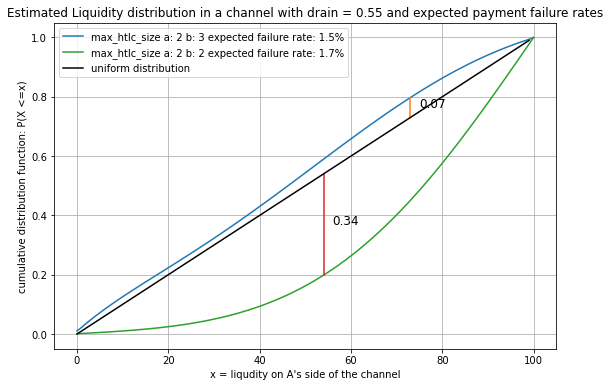

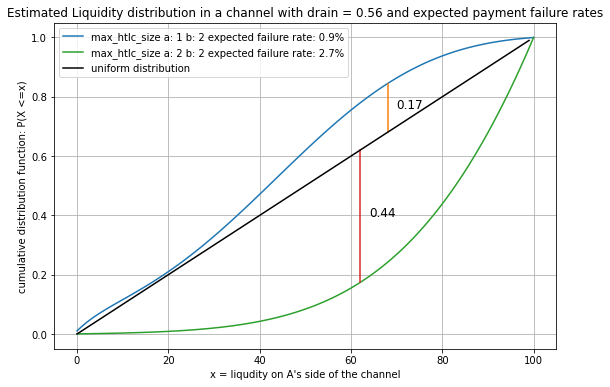

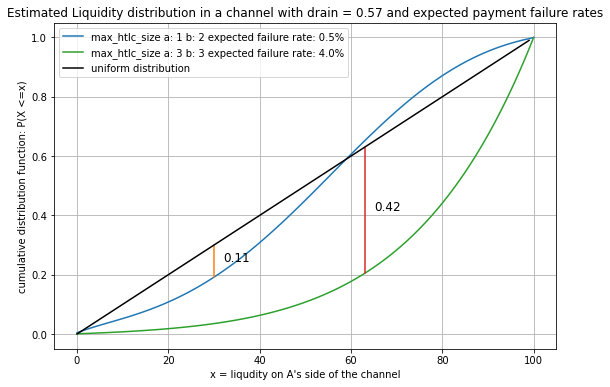

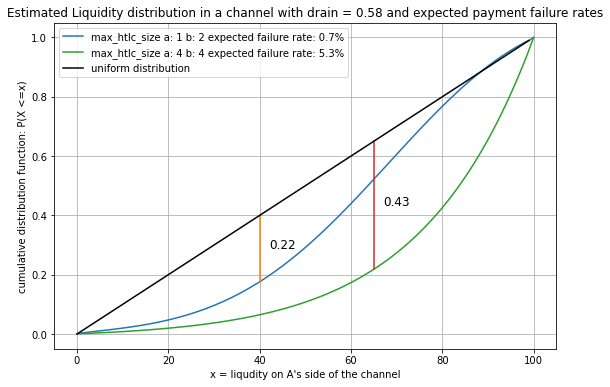

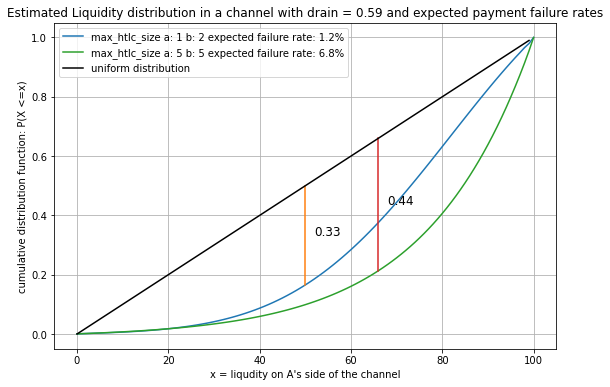

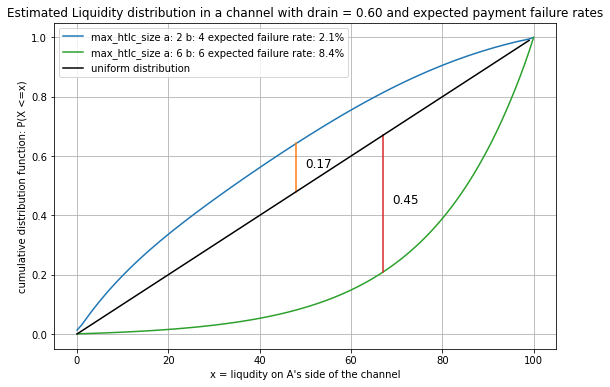

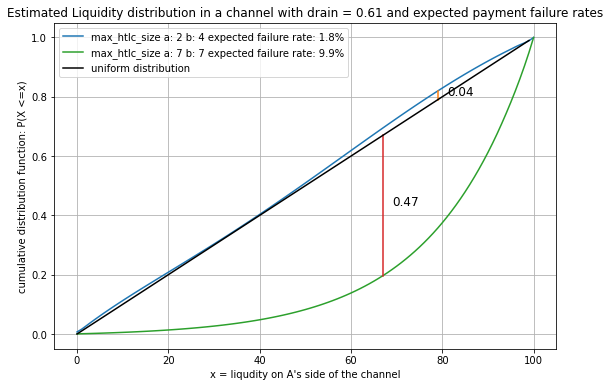

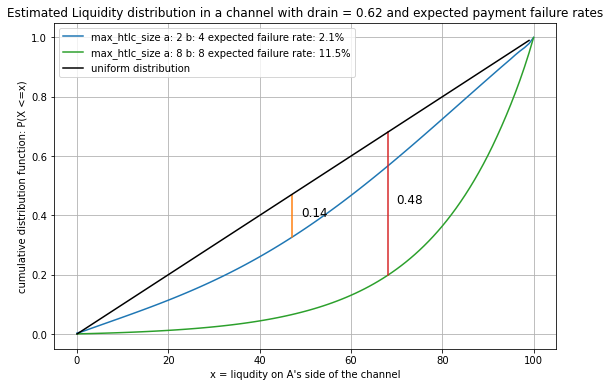

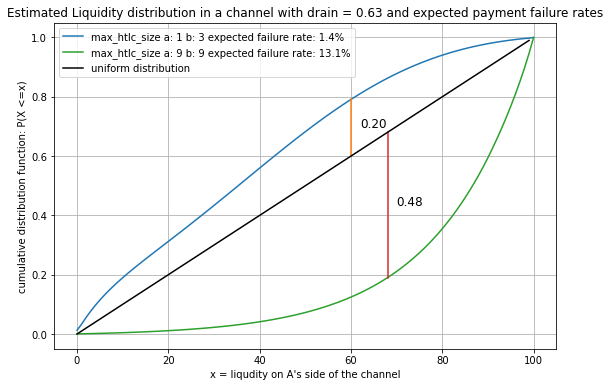

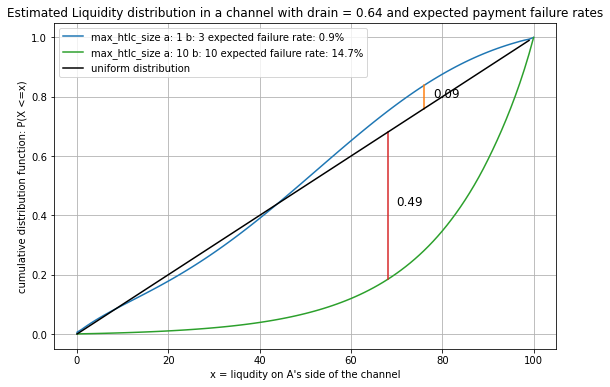

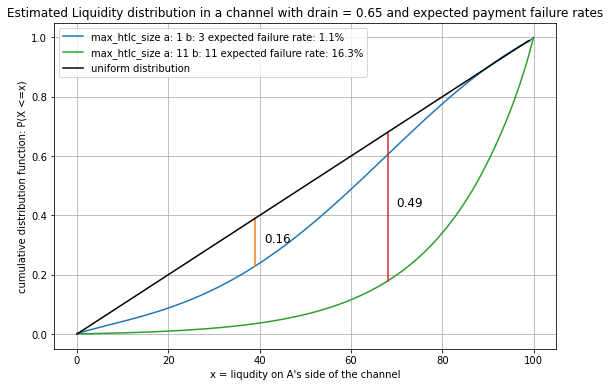

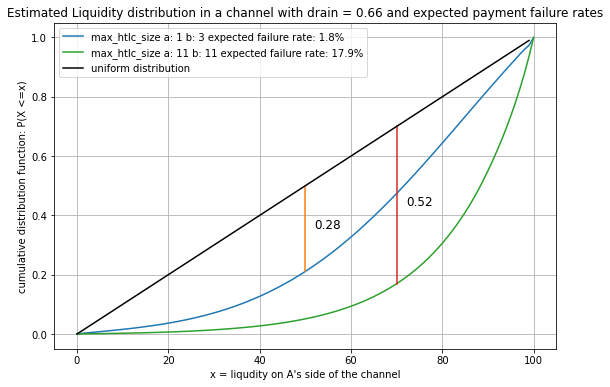

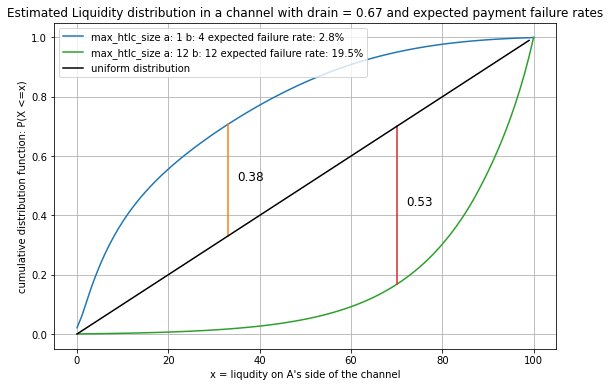

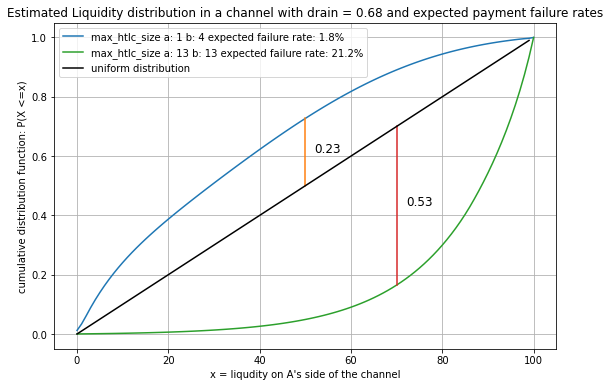

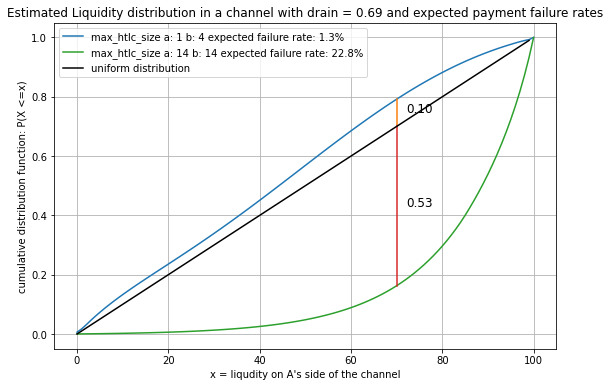

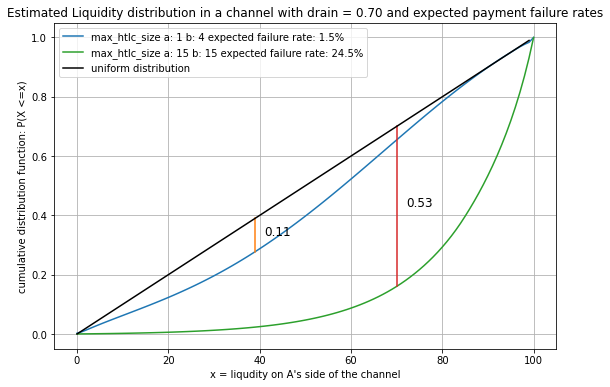

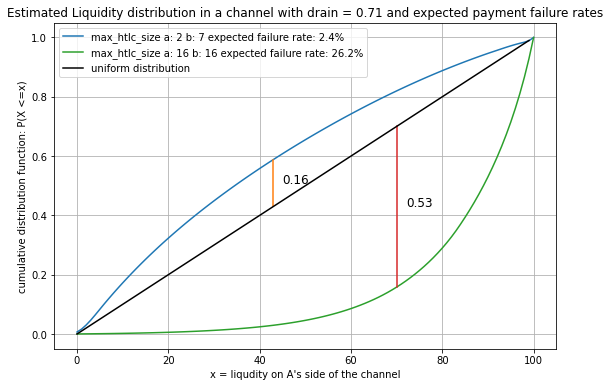

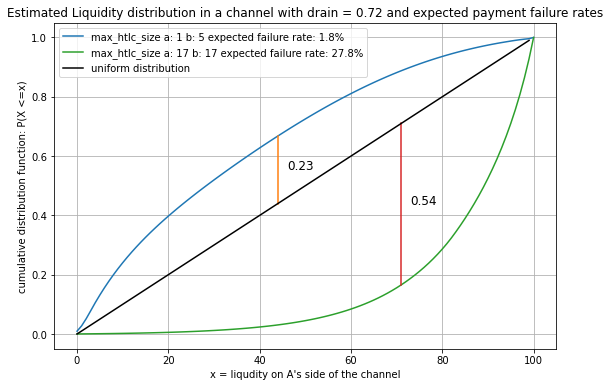

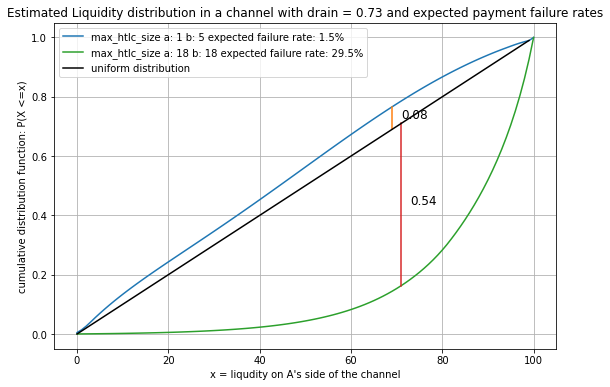

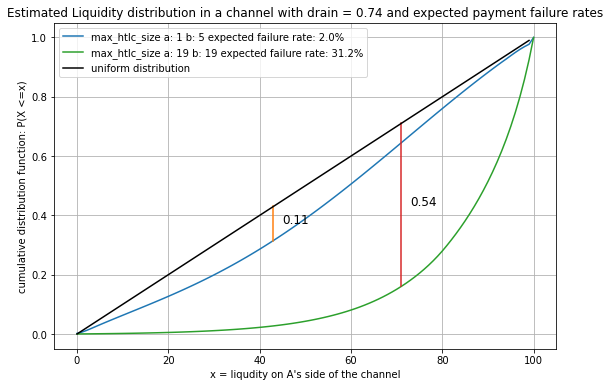

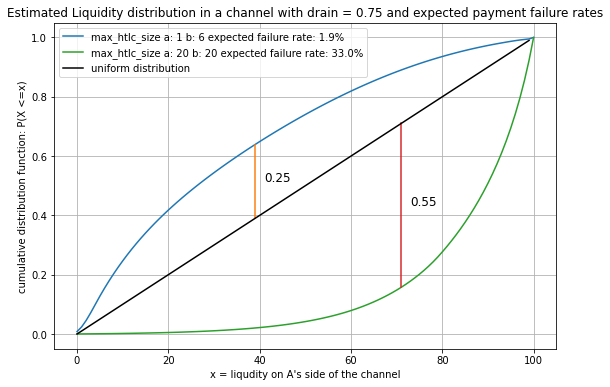

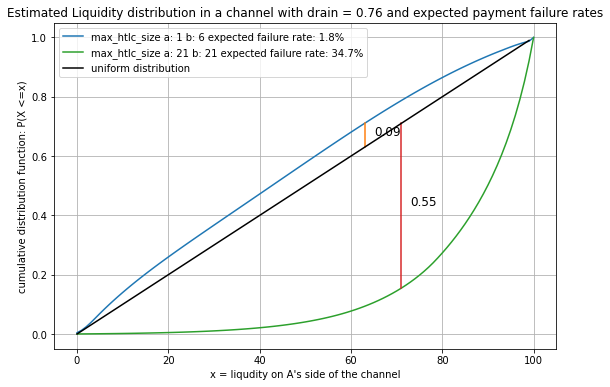

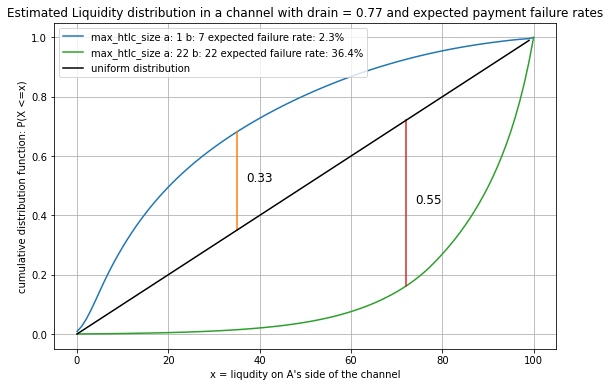

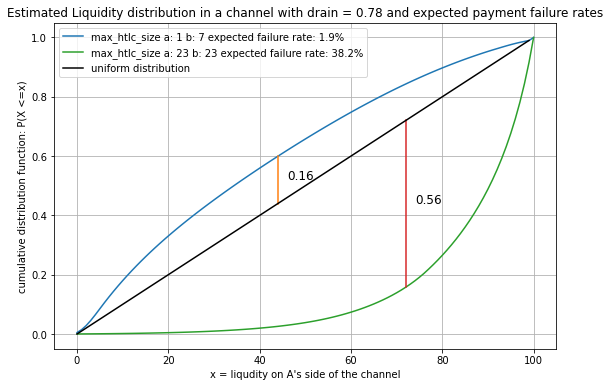

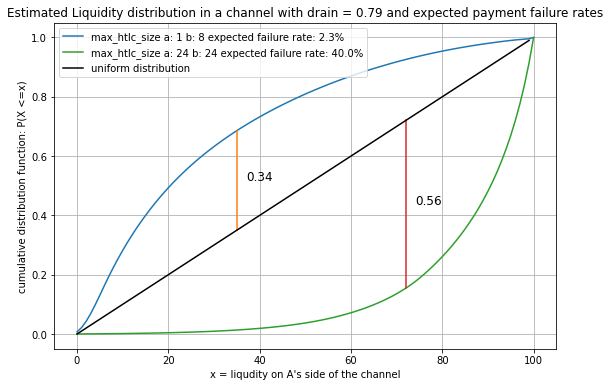

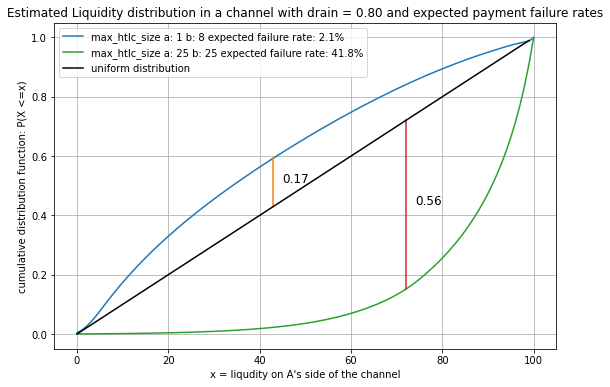

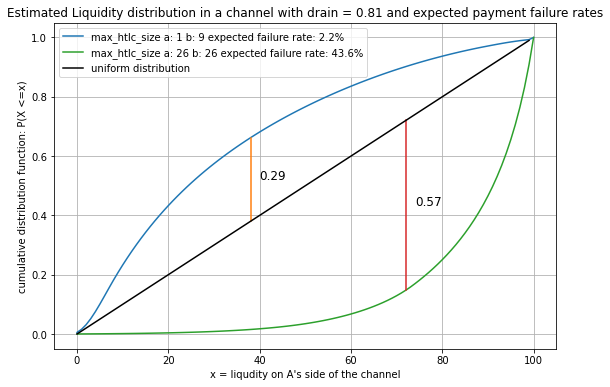

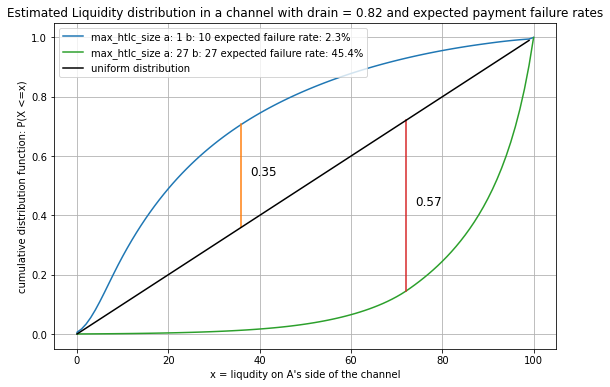

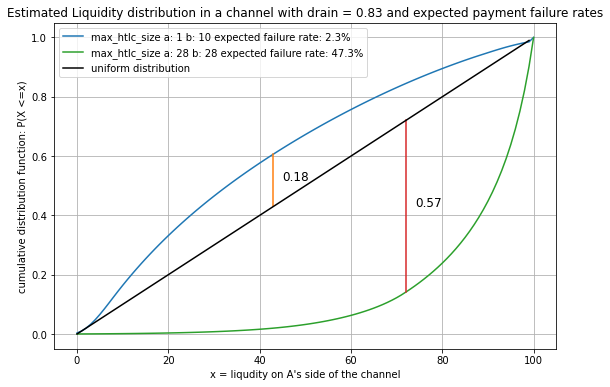

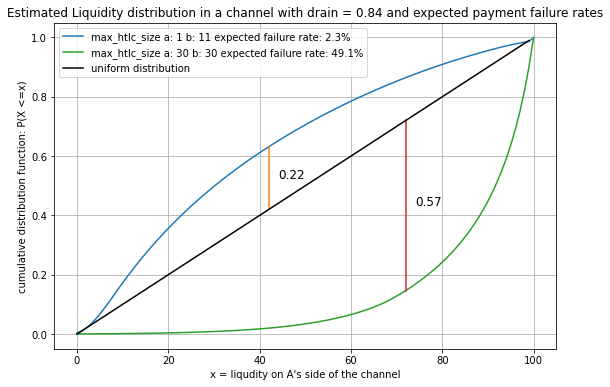

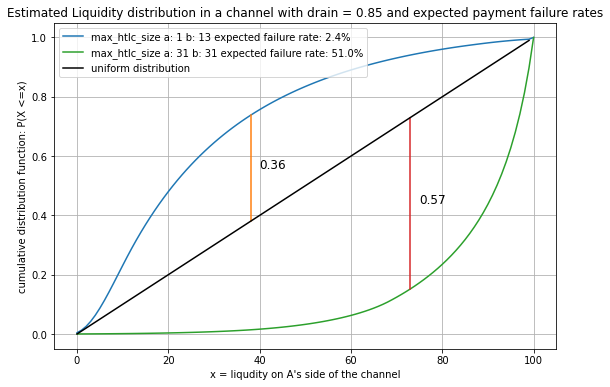

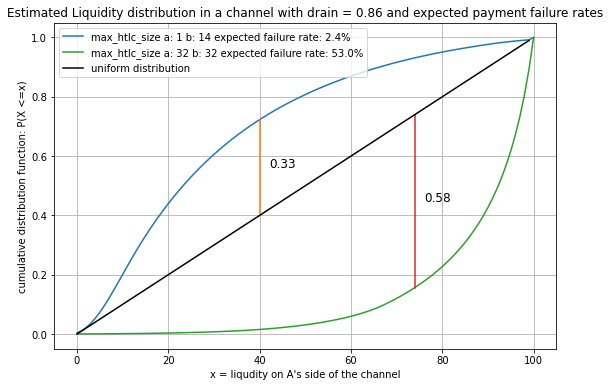

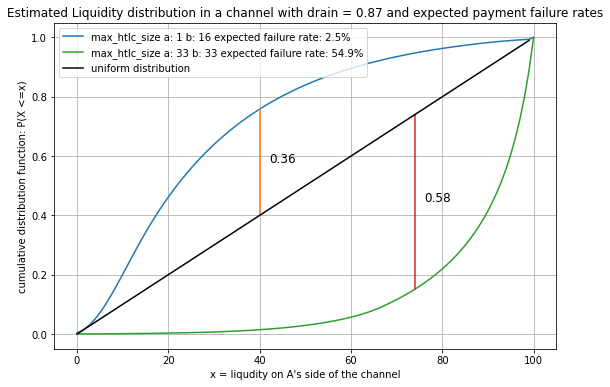

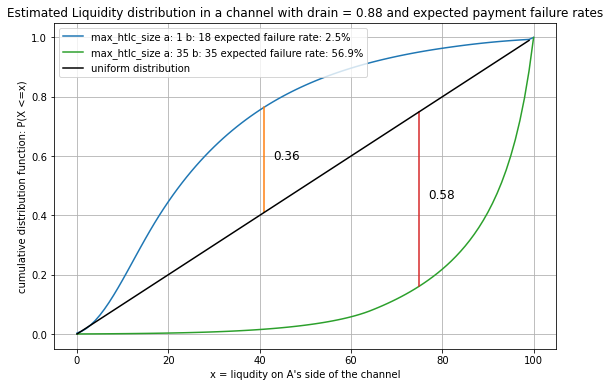

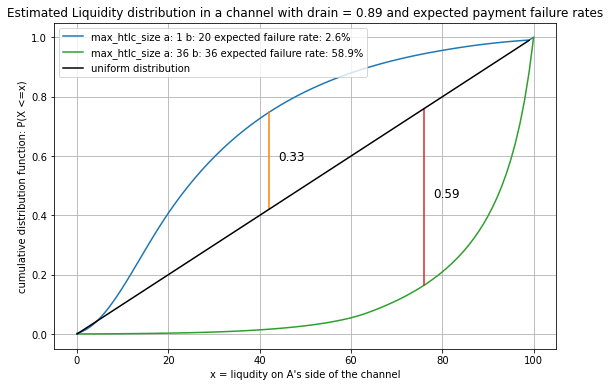

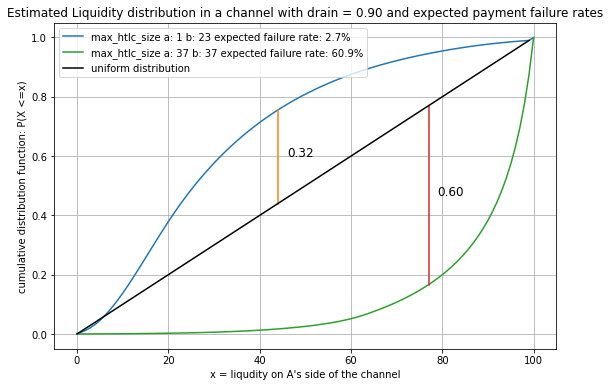

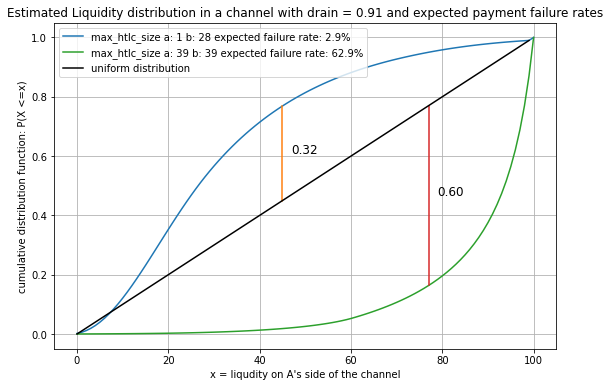

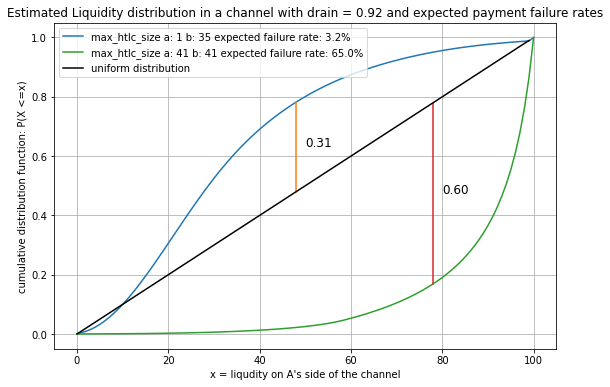

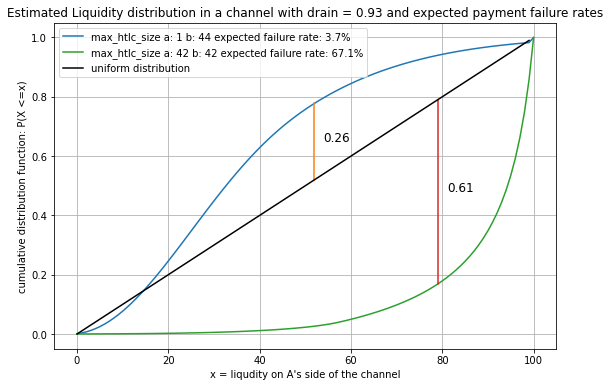

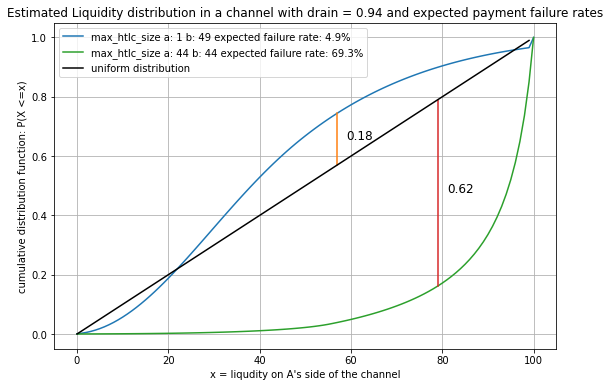

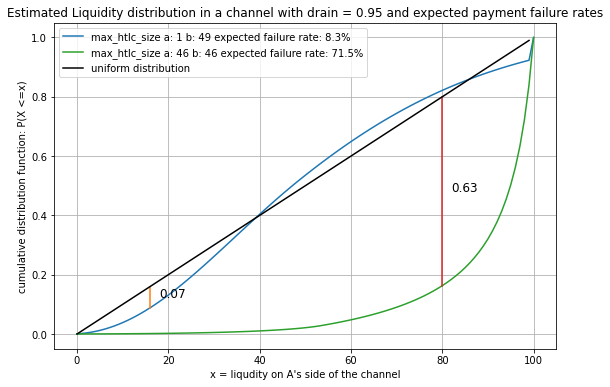

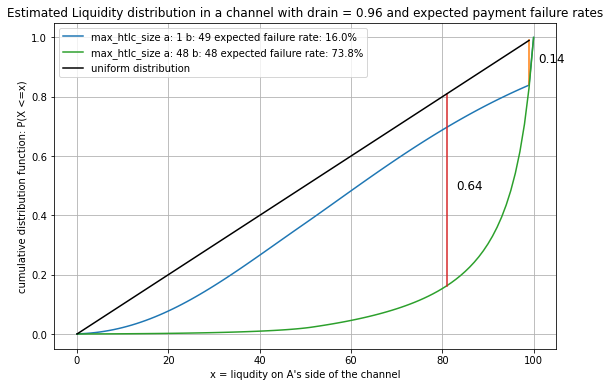

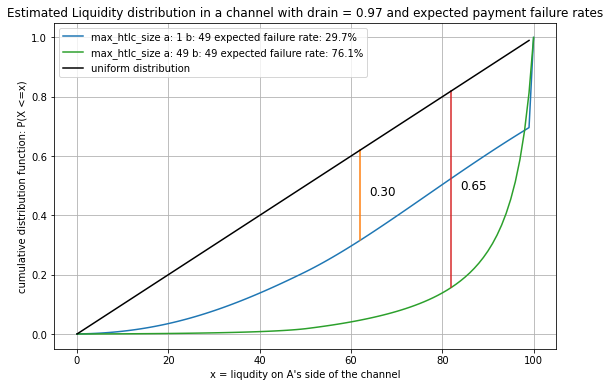

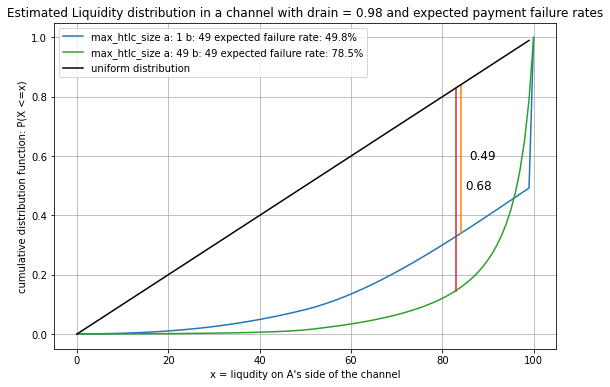

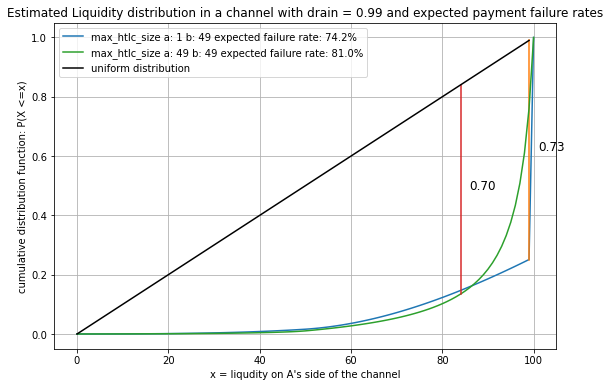

In [10]:
c = 100
max_fr = 1
params = []
uni = [i/c for i in range(c)]
for k, vals in enumerate(expected_asymmetric_failure_rates):
    error, sizes = vals
    a,b = sizes
    drain = 0.55+0.01*k
    plt.figure(figsize=(9,6))
    plt.title("Estimated Liquidity distribution in a channel with drain = {:4.2f} and expected payment failure rates".format(drain))
    x=compute_steady_state_vector_uni_amount_la(c,drain,a,b)
    ef = expected_failure_rate(x,drain,a,b)
    pos, distance = kolmogorov_smirnov_distance_to_uniform(np.cumsum(x))
    cdf = np.cumsum(x)
    plt.plot(cdf,label="max_htlc_size a: {} b: {} expected failure rate: {:3.1f}%".format(a,b,error*100))

    plt.plot([pos,pos],[uni[pos],cdf[pos]])
    plt.text(pos+2, (uni[pos]+cdf[pos])/2, "{:4.2f}".format(distance), fontsize=12)
    
    a = expected_symmetric_failure_rates[k][1]
    b = a
    drain = 0.5+0.01*k
    x=compute_steady_state_vector_uni_amount_la(c,drain,a,b)
    ef = expected_failure_rate(x,drain,a,b)
    pos, distance = kolmogorov_smirnov_distance_to_uniform(np.cumsum(x))
    
    cdf = np.cumsum(x)
    plt.plot(cdf,label="max_htlc_size a: {} b: {} expected failure rate: {:3.1f}%".format(a,b,expected_symmetric_failure_rates[k][0]*100))

    plt.plot([pos,pos],[uni[pos],cdf[pos]])
    plt.text(pos+2, (uni[pos]+cdf[pos])/2, "{:4.2f}".format(distance), fontsize=12)


    plt.plot(uni,"k",label="uniform distribution")
    
    plt.grid()
    plt.legend(loc="upper left")
    plt.ylabel("cumulative distribution function: P(X <=x)")
    plt.xlabel("x = liqudity on A's side of the channel")
    
    plt.show()

## EXPERIMENTAL: Non Markov Heuristic for Node Operators to find `max_htlc_size`

the idea is to look how far the liquidity distribution of the last x payments is from the uniform distribution and adopt `max_htlc_size` I am currently tracking 10k payments and look if the kolmogorov smirnoff distance is above or below the uniform distribution and decide by that if max_htlc_a or max_htlc_b has to be adopted. This is not working well yet but it avoids estimating the drain as a node operator and just looks at the distribution within a channel. I am sure better / more suitable methods can be done. I decided to show this as it may lead as inspiration to node operators to do their own experiments.

The clear advantage is that a mechanism like this one will not be limited by sparse matrix computations and can even in operation work easily on an actual channel

### Todo & Ideas
Probably binary search is not as good as using the kolmogorov smirnoff distance and error rate to estimate a step size. I already added a bit of randomness in stepsize selection but I am confident there are better options.

In [11]:
import random
from collections import Counter

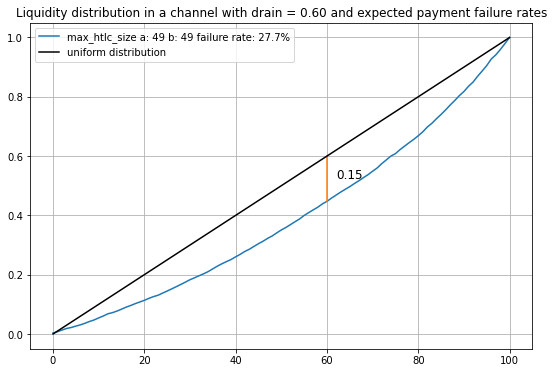

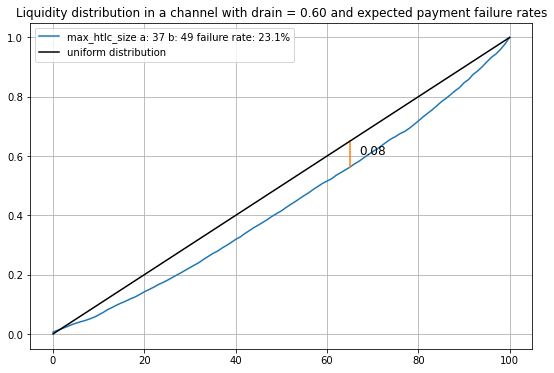

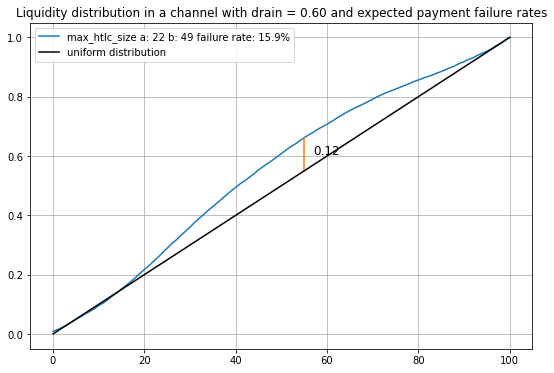

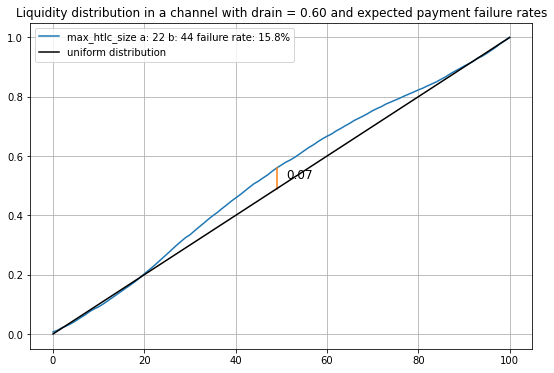

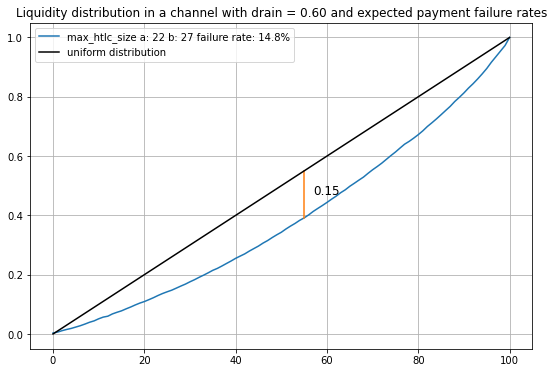

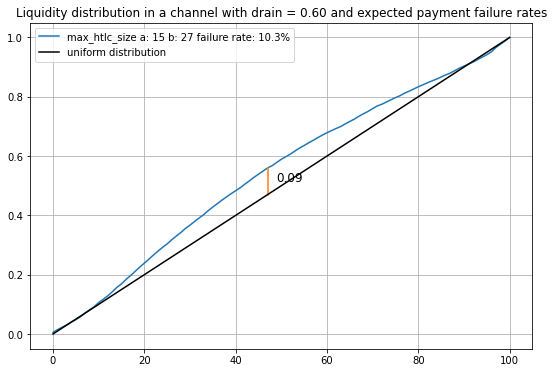

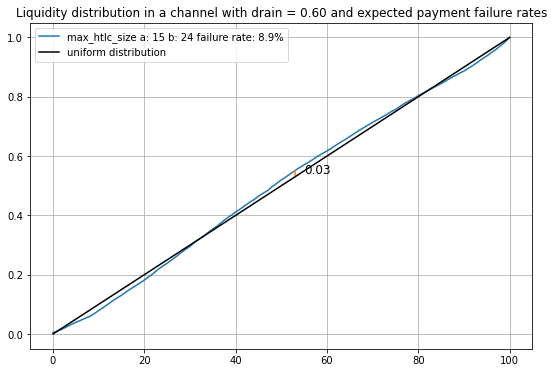

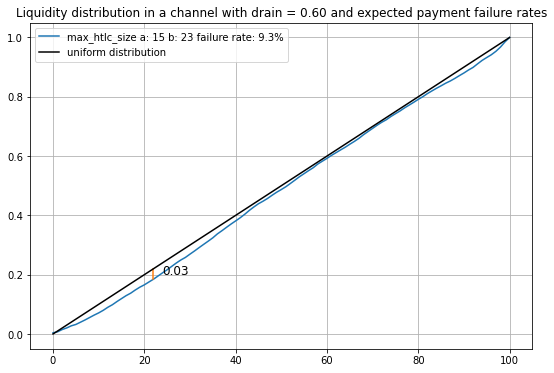

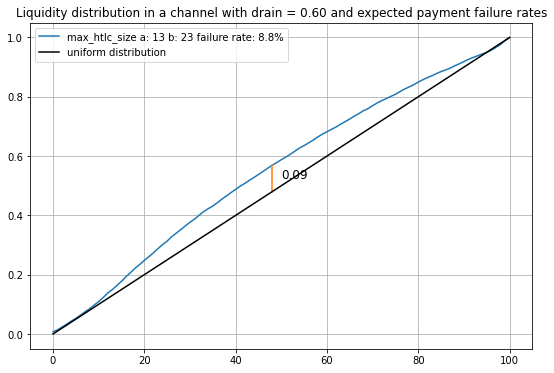

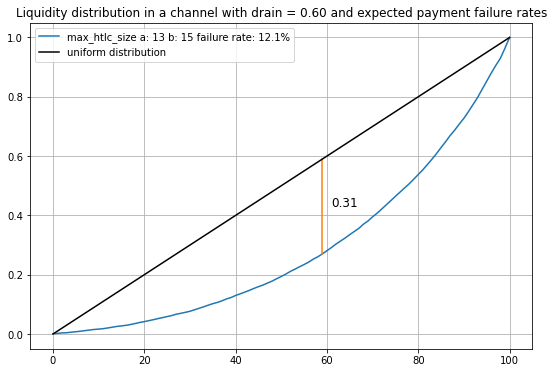

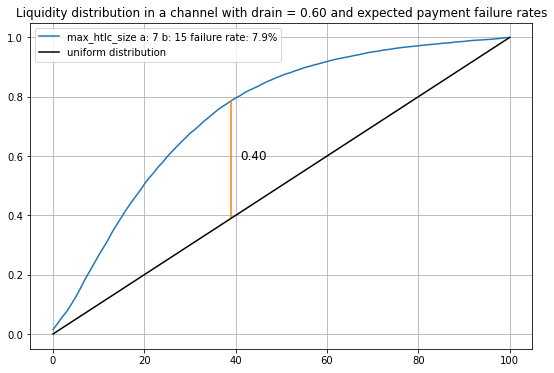

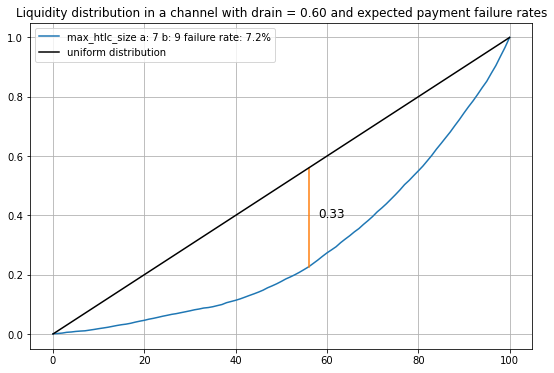

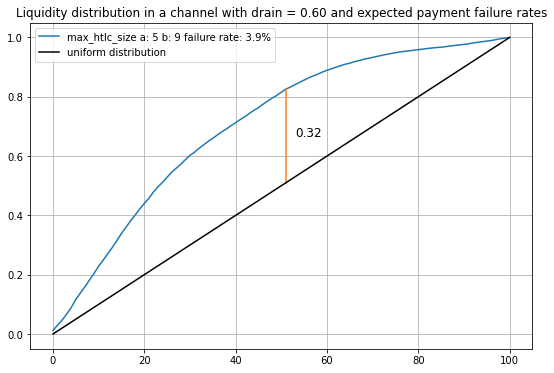

In [12]:
c = 100
drain = 0.6
max_a = 49
max_b = 49
A = 100

def simulate_payments_and_collect_stats(c,drain, max_a, max_b, A):
    liquidity_values = []
    payment_failure_rate = 0
    for i in range(10_000):
        if random.random() > drain:
            size = random.randint(1,max_b)
            if A - size >= 0:
                A -= size
            else:
                payment_failure_rate += 1
        else:
            size = random.randint(1,max_a)
            if A + size <= c:
                A += size
            else:
                payment_failure_rate += 1
        liquidity_values.append(A)
    return liquidity_values, payment_failure_rate/10_000

def plot_simulated_distribution(cdf,drain, a, b, failure_rate):
    uni = [i/100 for i in range(101)]
    pos, distance = kolmogorov_smirnov_distance_to_uniform(cdf)
    plt.figure(figsize=(9,6))
    plt.title("Liquidity distribution in a channel with drain = {:4.2f} and expected payment failure rates".format(drain))
    plt.plot(cdf,label="max_htlc_size a: {} b: {} failure rate: {:3.1f}%".format(a,b,failure_rate*100))
    plt.plot([pos,pos],[uni[pos],cdf[pos]])
    plt.text(pos+2, (uni[pos]+cdf[pos])/2, "{:4.2f}".format(distance), fontsize=12)
    plt.plot(uni,"k",label="uniform distribution")
    plt.grid()
    plt.legend(loc="upper left")
    plt.show()

failure_rate = 1

cnt = 0
while failure_rate > 0.05:    
    liquidity_values, failure_rate = simulate_payments_and_collect_stats(c,drain, max_a, max_b, A)
    A = liquidity_values[-1]
    count = Counter(liquidity_values)
    cdf = np.cumsum([count[i]/10_000 for i in range(101)])
    pos, distance = kolmogorov_smirnov_distance_to_uniform(cdf)
    plot_simulated_distribution(cdf, drain, max_a, max_b, failure_rate)
    
    if cdf[pos] - pos/100 < 0: #reduce max_htlc_size_a
        max_a= int(max_a/2) + random.randint(1, int(max_a/2))
    else:
        max_b= int(max_b/2) + random.randint(1, int(max_b/2))
    cnt +=1
    if cnt > 20:
        break


## Experimental: Interactive Round based max_htlc_size pair finding

The following code demonstrates how a peer can (assuming drain on the chennel) estimate its optimal max_htlc_size value for a given max_htlc_size value of its peer. Of course this can then be done in a round robin. We see that this protocol does end up in local minima and does not find the global best pair. However it seems good enough and interesting to study. 

In [13]:
def find_htlc_size_pair_heuristic(drain):
    a = 48
    b = 48
    c = 100
    
    low = 1
    val = None
    
    continue_search = True
    while continue_search == True:
        continue_search = False
        for i in range(1,a+1):
            x = compute_steady_state_vector_uni_amount_la(100,drain,i ,b)
            ef = expected_failure_rate(x,drain,i,b)
            if ef < low:
                low = ef
                val = (i,b)
        if a != val[0]:
            continue_search = True
            a = val[0]
            print("updating htlc_a to {} and keep htlc_b at: {}".format(val[0],val[1]))

        low = 1
        val = None
        for i in range(1,b+1):
            x = compute_steady_state_vector_uni_amount_la(100,drain,a ,i)
            ef = expected_failure_rate(x,drain,a,i)
            if ef < low:
                low = ef
                val = (a,i)
        if b != val[1]:
            continue_search = True
            b = val[1]
            print("keep htlc_a at {} and updating htlc_b at: {}".format(val[0],val[1]))
    x = compute_steady_state_vector_uni_amount_la(100,drain,a ,b)
    ef = expected_failure_rate(x,drain,a,b)
    print("Expexted failure rate: {:4.2f} for a channel with drain: {:4.2f}".format(ef,drain))
    
    
for i in range(50):
    drain = 0.5+i*0.01
    print("\n\t Find pair for drain {:4.2f}".format(drain))
    find_htlc_size_pair_heuristic(drain)
    



	 Find pair for drain 0.50
updating htlc_a to 30 and keep htlc_b at: 48
keep htlc_a at 30 and updating htlc_b at: 16
updating htlc_a to 15 and keep htlc_b at: 16
keep htlc_a at 15 and updating htlc_b at: 8
updating htlc_a to 9 and keep htlc_b at: 8
keep htlc_a at 9 and updating htlc_b at: 6
updating htlc_a to 7 and keep htlc_b at: 6
keep htlc_a at 7 and updating htlc_b at: 5
updating htlc_a to 6 and keep htlc_b at: 5
keep htlc_a at 6 and updating htlc_b at: 4
updating htlc_a to 5 and keep htlc_b at: 4
Expexted failure rate: 0.02 for a channel with drain: 0.50

	 Find pair for drain 0.51
updating htlc_a to 29 and keep htlc_b at: 48
keep htlc_a at 29 and updating htlc_b at: 15
updating htlc_a to 14 and keep htlc_b at: 15
keep htlc_a at 14 and updating htlc_b at: 8
updating htlc_a to 9 and keep htlc_b at: 8
keep htlc_a at 9 and updating htlc_b at: 5
updating htlc_a to 6 and keep htlc_b at: 5
keep htlc_a at 6 and updating htlc_b at: 4
updating htlc_a to 5 and keep htlc_b at: 4
keep htlc_a

updating htlc_a to 10 and keep htlc_b at: 21
keep htlc_a at 10 and updating htlc_b at: 19
updating htlc_a to 9 and keep htlc_b at: 19
keep htlc_a at 9 and updating htlc_b at: 17
updating htlc_a to 8 and keep htlc_b at: 17
keep htlc_a at 8 and updating htlc_b at: 15
updating htlc_a to 7 and keep htlc_b at: 15
keep htlc_a at 7 and updating htlc_b at: 13
Expexted failure rate: 0.05 for a channel with drain: 0.63

	 Find pair for drain 0.64
updating htlc_a to 15 and keep htlc_b at: 48
keep htlc_a at 15 and updating htlc_b at: 29
updating htlc_a to 12 and keep htlc_b at: 29
keep htlc_a at 12 and updating htlc_b at: 24
updating htlc_a to 11 and keep htlc_b at: 24
keep htlc_a at 11 and updating htlc_b at: 22
updating htlc_a to 10 and keep htlc_b at: 22
keep htlc_a at 10 and updating htlc_b at: 20
updating htlc_a to 9 and keep htlc_b at: 20
keep htlc_a at 9 and updating htlc_b at: 18
updating htlc_a to 8 and keep htlc_b at: 18
keep htlc_a at 8 and updating htlc_b at: 16
updating htlc_a to 7 an

Expexted failure rate: 0.05 for a channel with drain: 0.80

	 Find pair for drain 0.81
updating htlc_a to 5 and keep htlc_b at: 48
keep htlc_a at 5 and updating htlc_b at: 33
updating htlc_a to 4 and keep htlc_b at: 33
keep htlc_a at 4 and updating htlc_b at: 26
Expexted failure rate: 0.05 for a channel with drain: 0.81

	 Find pair for drain 0.82
updating htlc_a to 4 and keep htlc_b at: 48
keep htlc_a at 4 and updating htlc_b at: 29
Expexted failure rate: 0.05 for a channel with drain: 0.82

	 Find pair for drain 0.83
updating htlc_a to 4 and keep htlc_b at: 48
keep htlc_a at 4 and updating htlc_b at: 32
updating htlc_a to 3 and keep htlc_b at: 32
keep htlc_a at 3 and updating htlc_b at: 24
Expexted failure rate: 0.04 for a channel with drain: 0.83

	 Find pair for drain 0.84
updating htlc_a to 4 and keep htlc_b at: 48
keep htlc_a at 4 and updating htlc_b at: 35
updating htlc_a to 3 and keep htlc_b at: 35
keep htlc_a at 3 and updating htlc_b at: 26
Expexted failure rate: 0.05 for a ch

## Statistics of the network and max_htlc_size usage

We look how the max_htlc_size value is being used on a current snapshot of the network to estimate if node operators are aware of the potentials

In [14]:
import json

In [15]:
def stats_on_max_htlc_size_settings(dataset):
    print("\n\t statistics on ", dataset)
    f = open(dataset)
    channels = json.load(f)["channels"]
    d = {}
    sids = {}
    max_htlc_sizes = []
    cnt = 0
    for c in channels:
        max_htlc_size = int(int(c["htlc_maximum_msat"][:-4])/1000)
        sid = c["short_channel_id"]
        
        capacity = int(c["satoshis"])
        node_id = c["source"]
        if capacity == max_htlc_size:
            cnt +=1
            continue
        #max_htlc_sizes.append(max_htlc_size)
        if node_id in d:
            d[node_id].add(max_htlc_size)
        else:
            d[node_id]=set()
            d[node_id].add(max_htlc_size)

        #TODO: should we move this up before the capacity == max_htlc_size or is it fair to exclode those?
        if sid in sids:
            sids[sid].append(max_htlc_size)
        else:
            sids[sid]=[max_htlc_size]

    print("{:4.2f}% of channels keep max_htlc_size at the capacity of the channel".format(100* cnt / len(channels)))
    cnt = 0
    for node, sizes in d.items():
        if len(sizes) == 1:
            cnt+=1
    print("{:4.2f}% of all nodes have the same HTLC size (excluding channels with htlc_size = capacity)".format(100* cnt / len(d)))

    
    max_htlc_sizes=[]
    total = 0
    same = 0
    for sid, vals in sids.items():
        # skipp channels for which we only have gossip in one direction
        if len(vals)!=2:
            continue
        total +=1
        if vals[0]==vals[1]:
            same+=1
        max_htlc_sizes.append(vals[0])
        max_htlc_sizes.append(vals[1])

    print("Fraction of channels with the same max_htlc_size value in both directions: {:4.2f}%".format(100*same/total))
    print("This is {} out of {} channels seen on September 15th 2022".format(same, total))
    return max_htlc_sizes




	 statistics on  listchannels20220915.json
12.05% of channels keep max_htlc_size at the capacity of the channel
33.28% of all nodes have the same HTLC size (excluding channels with htlc_size = capacity)
Fraction of channels with the same max_htlc_size value in both directions: 84.75%
This is 46977 out of 55432 channels seen on September 15th 2022


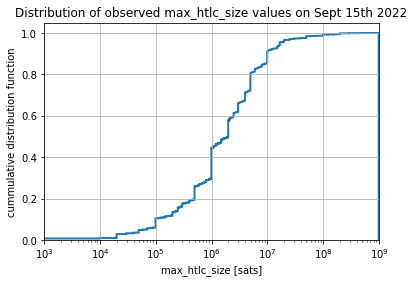


	 statistics on  listchannels20220412.json
8.10% of channels keep max_htlc_size at the capacity of the channel
49.76% of all nodes have the same HTLC size (excluding channels with htlc_size = capacity)
Fraction of channels with the same max_htlc_size value in both directions: 92.44%
This is 57382 out of 62075 channels seen on September 15th 2022


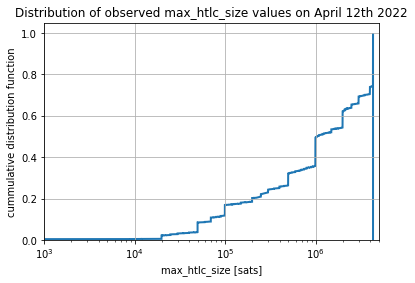

In [16]:
plt.title("Distribution of observed max_htlc_size values on Sept 15th 2022")

max_htlc_sizes = stats_on_max_htlc_size_settings("listchannels20220915.json")
        
plt.hist(max_htlc_sizes,bins = 100000,density=True,cumulative=True,histtype="step", linewidth=2)

plt.grid()
plt.xscale("log")
plt.xlim(1000,10**9)
plt.xlabel("max_htlc_size [sats]")
plt.ylabel("cummulative distribution function")
plt.show()

plt.title("Distribution of observed max_htlc_size values on April 12th 2022")
max_htlc_sizes = stats_on_max_htlc_size_settings("listchannels20220412.json")
        
plt.hist(max_htlc_sizes,bins = 100000,density=True,cumulative=True,histtype="step", linewidth=2)

plt.grid()
plt.xscale("log")
plt.xlim(1000,5*10**6)
plt.xlabel("max_htlc_size [sats]")
plt.ylabel("cummulative distribution function")
plt.show()



## Backup, loose ends & open ideas

Theoretically we should be able to improve the runtime and numerical stability with solvers that are specialized for band matrices. However our equation system always has the zero vector as the trivial solution which is also being found by the library. Unfortunatelly we are not interested in the zero vector (we seek a solution under the constrain that it is normed to 1 which is impossible for the zero vector)

In [17]:
from scipy.linalg import solve_banded


def steady_state_vector_banded(capacity, drain,max_htlc_size_a, max_htlc_size_b):
    dimension = capacity +1
    ab = np.zeros((max_htlc_size_a + max_htlc_size_b + 1,dimension))

    for i in range(max_htlc_size_b):
        for j in range(max_htlc_size_b-i, dimension):
            ab[i,j]=drain/max_htlc_size_b
    
    for i in range(max_htlc_size_a):
        for j in range(dimension-i-1):
            ab[max_htlc_size_b+1+i,j]=(1-drain)/max_htlc_size_a
    for j in range(0,dimension):
        ab[max_htlc_size_b,j]=-1
        if j < max_htlc_size_a:
            ab[max_htlc_size_b,j]+=(1-drain)*(1-(j)/max_htlc_size_a)
        if j >= dimension - max_htlc_size_b:
            ab[max_htlc_size_b,j]+=(drain)*(1-(dimension-j-1)/max_htlc_size_b)
    b = np.zeros(dimension)
    #b[0]=0
    x = solve_banded((max_htlc_size_a,max_htlc_size_b),ab,b)
    print(x)
    print(ab)
    
steady_state_vector_banded(7,0.6,2,4)

[-0. -0. -0. -0. -0. -0. -0. -0.]
[[ 0.    0.    0.    0.    0.15  0.15  0.15  0.15]
 [ 0.    0.    0.    0.15  0.15  0.15  0.15  0.15]
 [ 0.    0.    0.15  0.15  0.15  0.15  0.15  0.15]
 [ 0.    0.15  0.15  0.15  0.15  0.15  0.15  0.15]
 [-0.6  -0.8  -1.   -1.   -0.85 -0.7  -0.55 -0.4 ]
 [ 0.2   0.2   0.2   0.2   0.2   0.2   0.2   0.  ]
 [ 0.2   0.2   0.2   0.2   0.2   0.2   0.    0.  ]]
